In [148]:
import pyart
import boto3
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import torch
import torchvision

from botocore import UNSIGNED
from torchvision.io import decode_image
from torchvision import transforms
from botocore.config import Config
from datetime import datetime, timedelta
from scipy.ndimage import center_of_mass, label

Lat and lon range for domain and location of our instrument.

In [37]:
lat_range = [41.1280, 42.5680]
lon_range = [-88.7176, -87.2873]

mobotix_loc = [41.70101404798476, -87.99577278662817]

Let's get the latest time available from KLOT NEXRAD scan.

In [172]:
right_now = datetime.utcnow()
yesterday = right_now - timedelta(days=1)
year = right_now.year
month = right_now.month
day = right_now.day

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
bucket_name = 'noaa-nexrad-level2'
radar = "KLOT"
prefix = f'{year}/{month:02d}/{day:02d}/{radar}'
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
file_list = [x['Key'] for x in response['Contents']]

# Find yesterday's scans
prefix = f'{yesterday.year}/{yesterday.month:02d}/{yesterday.day:02d}/{radar}'
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
file_list = file_list + [x['Key'] for x in response['Contents']]

time_list = []
for filepath in file_list:
    name = filepath.split("/")[-1]
    if name[-3:] == "MDM":
        time_list.append(datetime.strptime(name, f"{radar}%Y%m%d_%H%M%S_V06_MDM"))
    else:
        time_list.append(datetime.strptime(name, f"{radar}%Y%m%d_%H%M%S_V06"))
    
time_list = np.array(time_list)
cur_time = time_list[np.argmin(np.abs(time_list - right_now))]
path = "s3://noaa-nexrad-level2/" + file_list[np.argmin(np.abs(time_list - right_now))]
print(path)

s3://noaa-nexrad-level2/2025/03/25/KLOT/KLOT20250325_184123_V06


In [173]:
cur_radar = pyart.io.read_nexrad_archive(path)

Preprocess the radar scan for the ResNet50 model. We have to save to a .png then load using torchvision's modules. After that, we perform a transform that normalized the image content to be consistent with the expected input of FCN-ResNet50.

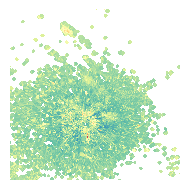

In [174]:
dpi = 150
disp = pyart.graph.RadarMapDisplay(cur_radar)
fig, ax = plt.subplots(1, 1, figsize=(256/dpi, 256/dpi),
        subplot_kw=dict(projection=ccrs.PlateCarree(), frameon=False))

disp.plot_ppi_map('reflectivity', sweep=1, min_lon=lon_range[0],
        ax=ax, max_lon=lon_range[1], min_lat=lat_range[0], max_lat=lat_range[1],
        embellish=False, vmin=-30, vmax=60, cmap='Spectral_r',
        add_grid_lines=False, colorbar_flag=False, title_flag=False)
ax.set_axis_off()
fig.tight_layout(pad=0, w_pad=0, h_pad=0)
fig.savefig('temp.png', dpi=150)

In [175]:
image = decode_image('temp.png')
image = image[:3, :, :].float()
transform = transforms.Compose([
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
image = torch.stack([transform(image)])

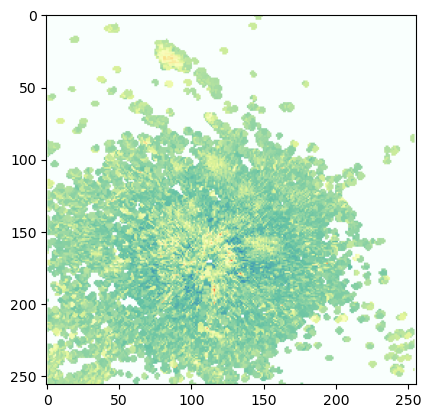

In [176]:
plt.imshow(np.transpose(image[0], [1, 2, 0])/image.max())

Load the pretrained model.

In [91]:
model = torch.load('epoch99.pickle', weights_only=False, map_location=torch.device('cpu'))

Make our prediction.

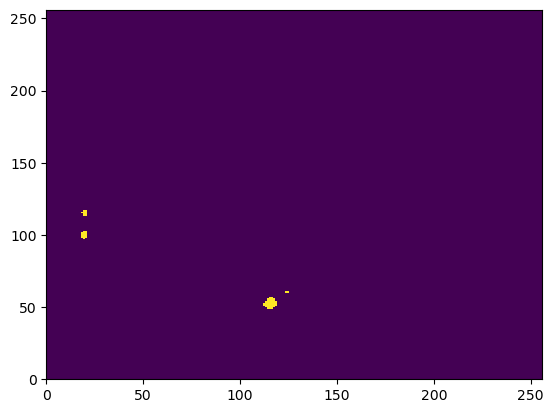

In [177]:
mask = model(image)['out'].detach().numpy()
mask = mask[0].argmax(axis=0)
plt.pcolormesh(mask)

Filter out small regions.
The model will sometime predict false alarms, which seem to particularly be < 10 pixels in area. Let's filter those out of the mask.

In [178]:
labels, num_features = label(mask)
area_threshold = 20
print(num_features)
for i in range(num_features):
    area = mask[labels == i+1].sum()
    if area < area_threshold:
        mask[labels == i+1] = 0

4


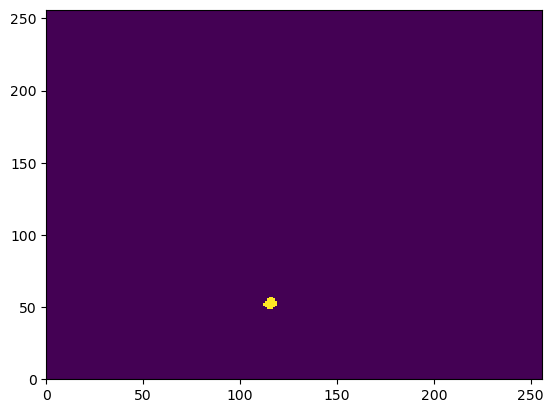

In [179]:
plt.pcolormesh(mask)

Let's get the angle where we should point the instrument. We will draw a line between the center of mass and the instrument.

In [180]:
lats = np.linspace(lat_range[1], lat_range[0], 256)
lons = np.linspace(lon_range[1], lon_range[0], 256)
lat_index = np.argmin(np.abs(lats - mobotix_loc[1]))
lon_index = np.argmin(np.abs(lons - mobotix_loc[0]))
center = center_of_mass(mask)
angle = np.atan2(-(center[1] - lat_index), (center[0] - lon_index))
if angle < 0:
    angle = angle + 2 * np.pi
deg_angle = np.rad2deg(angle)
if np.isnan(deg_angle):
    print("We are not triggering the mobotix")
else:
    print(f"We will point the mobotix at {deg_angle:.2f} degrees")

We will point the mobotix at 69.52 degrees


Plot our prediction on a map.

Text(-87.99577278662817, 41.70101404798476, 'X')

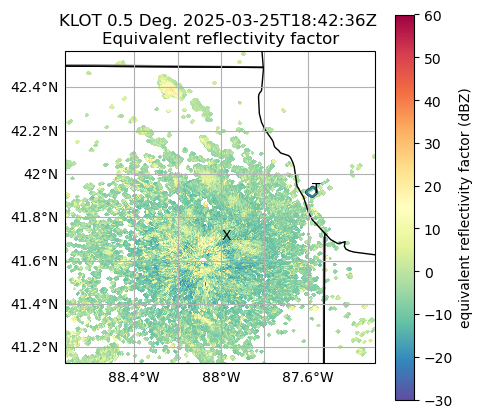

In [185]:
lats = np.linspace(lat_range[1], lat_range[0], 256)
lons = np.linspace(lon_range[1], lon_range[0], 256)
lat_index = int(center[1])
lon_index = int(center[0])
lons, lats = np.meshgrid(lons, lats, indexing='ij')
disp = pyart.graph.RadarMapDisplay(cur_radar)
fig, ax = plt.subplots(1, 1, figsize=(5, 5),
        subplot_kw=dict(projection=ccrs.PlateCarree()))
disp.plot_ppi_map('reflectivity', sweep=1, min_lon=lon_range[0],
        ax=ax, max_lon=lon_range[1], min_lat=lat_range[0], max_lat=lat_range[1],
        lat_lines=[41.2, 41.4, 41.6, 41.8, 42, 42.2, 42.4],
        lon_lines=[-88.4, -88.2, -88, -87.8, -87.6],
        vmin=-30, vmax=60, cmap='Spectral_r')
        
ax.coastlines()
ax.add_feature(cfeature.STATES)
ax.contour(lons, lats, mask, levels=1)
ax.text(lons[lon_index, lat_index], lats[lon_index, lat_index], 'T')
ax.text(mobotix_loc[1], mobotix_loc[0], 'X')